Code for Graphs that I will make for my final submission.
==============================
There may be some repeats of graphs made in other documents. However, this notebook was made after I realized my mistake with the data, hence it seems reseaoanble to start over and make the graphs again.

# Contents:
- [Preliminary](#Preliminary)
- [Predicted vs Actual](#Predicted-vs-Actual)
- [d180 over Time for each Station](#d180-over-Time-for-each-Station)
- [Residuals](#Residuals)

# Preliminary

### Setup
Importing necessary libraries and setting colour palette and theme for the graphs.

In [39]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# Set the SeaBorn theme to persist across plots
sns.set_theme(style="darkgrid",
              palette="hls")
palette = sns.color_palette("hls", 8)
palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

### Data
Reading the data and modyfying it to be used for the graphs and is easier access.

In [41]:
# Load in orginal isodata (the training data)
stationData = pd.read_csv('Isoscape_Data.csv')

# Extract only the stations and their coordinates
stations = stationData[['Station', 'Lat', 'Long']].drop_duplicates()
stationsList = stations['Station'].tolist()

stations = stations.set_index('Station')

In [42]:
# Load in results and isoP
results = pd.read_csv('results_test.csv')
isoP = pd.read_csv('isoP_Output.csv')
results.rename(columns={'Precipitation (kg/m^2/s)': 'Precip',
                        'Temperature (K)': 'Temp'}, inplace=True)

# Go through results and take Year and Day of Year [Day] into one Date column
results['Date'] = pd.to_datetime(results['Year'].astype(str) + results['Day'].astype(str).str.zfill(3), format='%Y%j')
results.drop(columns=['Year', 'Day'], inplace=True)
# Set the results Date to be at first of every month rather than the 2nd
results['Date'] = results['Date'] - pd.Timedelta(days=1)

# Go through isoP and take Year and Month into one Date column
isoP['Date'] = pd.to_datetime(isoP['Year'].astype(str) + isoP['Month'].astype(str).str.zfill(2), format='%Y%m')
isoP.drop(columns=['Year', 'Month'], inplace=True)

In [43]:
# Add Station to results and isoP via similar coordinates
for station in stationsList:
    lat = stations.loc[station, 'Lat']
    long = stations.loc[station, 'Long']

    # Find every station that is the same coordinates
    results.loc[results['Lat'] == lat, 'Station'] = station
    results.loc[results['Long'] == long, 'Station'] = station
    isoP.loc[isoP['Lat'] == lat, 'Station'] = station
    isoP.loc[isoP['Lon'] == long, 'Station'] = station


# Predicted vs Actual

In [51]:
# Calculate coefficient of determination for total
from sklearn.metrics import r2_score
r2 = r2_score(results['Actual'], results['Predictions'])

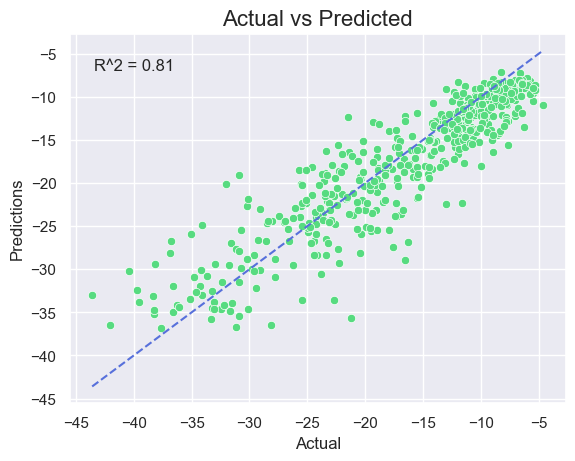

In [59]:
# Create the graph
pva = sns.scatterplot(x='Actual', y='Predictions', data=results, color=palette[3])

# Add the line of best fit
sns.lineplot(x=results['Actual'], y=results['Actual'], linestyle='--', color=palette[5])

# Annotate and add the R^2 value
pva.annotate(f'R^2 = {r2:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

# Add title and labels
pva.set_title('Actual vs Predicted', fontsize=16)
plt.show()
plt.close()

# d180 over Time for each Station
This graph will be a grid showing the preidcted d180 from isoNet and isoP for each station over time, as well as the actual d180.